In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

CUDA available: True
Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 1. Install Kaggle library
!pip install -q kaggle

# 2. Upload kaggle.json file
from google.colab import files
print("Upload your kaggle.json file:")
files.upload()

# 3. Setup Kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# 5. Unzip the data
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.76GB/s]


Classes: ['REAL', 'FAKE']


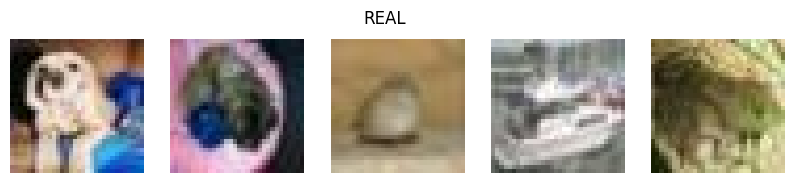

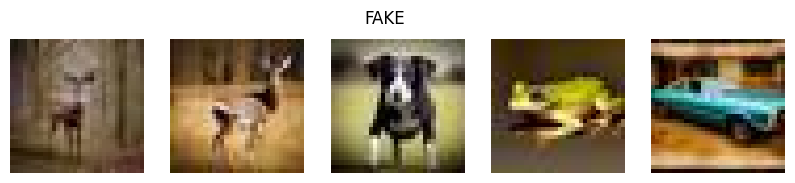

In [6]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

dataset_path = "train"

classes = os.listdir(dataset_path)
print("Classes:", classes)

# Show random images from each class
def show_samples(class_name, n=5):
    class_path = os.path.join(dataset_path, class_name)
    images = random.sample(os.listdir(class_path), n)

    plt.figure(figsize=(10,2))
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(class_path, img_name))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(class_name)
    plt.show()

for c in classes:
    show_samples(c)

In [7]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# 1. Load the full training dataset and test
full_train_dataset = ImageFolder("train", transform=transform)
test_dataset = ImageFolder("test", transform=transform)

# 2. Split into Train (80%) and Validation (20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_sub, val_sub = random_split(full_train_dataset, [train_size, val_size])

# 3. Create Loaders
train_loader = DataLoader(train_sub, batch_size=128, shuffle=True)
val_loader = DataLoader(val_sub, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training images: {len(train_sub)}, Validation images: {len(val_sub)}")

Training images: 80000, Validation images: 20000


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

In [11]:
from tqdm import tqdm

def train_model(model, loader, epochs=5):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch {epoch+1}: Loss {total_loss/len(loader):.4f}, Accuracy {100*correct/total:.2f}%")

In [ ]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only final layer
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

print("Stage 1: Training classifier head")
train_model(model, train_loader, epochs=5)

Stage 1: Training classifier head


100%|██████████| 625/625 [04:01<00:00,  2.59it/s]


Epoch 1: Loss 0.3626, Accuracy 83.97%


100%|██████████| 625/625 [04:07<00:00,  2.53it/s]


Epoch 2: Loss 0.3008, Accuracy 87.27%


100%|██████████| 625/625 [03:55<00:00,  2.65it/s]


Epoch 3: Loss 0.2928, Accuracy 87.62%


100%|██████████| 625/625 [03:56<00:00,  2.64it/s]


Epoch 4: Loss 0.2895, Accuracy 87.76%


100%|██████████| 625/625 [03:57<00:00,  2.63it/s]

Epoch 5: Loss 0.2863, Accuracy 87.98%


In [12]:
PROJECT_PATH = "/content/drive/MyDrive/SynthShieldAI"


In [14]:
stage1_path = os.path.join(PROJECT_PATH, "guardian_stage1.pth")

torch.save({
    'model_state_dict': model.state_dict(),
}, stage1_path)

print("Stage 1 model saved at:", stage1_path)

Stage 1 model saved at: /content/drive/MyDrive/SynthShieldAI/guardian_stage1.pth


In [ ]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-5)

print("Stage 2: Fine-tuning entire model")
train_model(model, train_loader, epochs=5)

Stage 2: Fine-tuning entire model


100%|██████████| 625/625 [06:26<00:00,  1.62it/s]


Epoch 1: Loss 0.1663, Accuracy 93.43%


100%|██████████| 625/625 [06:29<00:00,  1.60it/s]


Epoch 2: Loss 0.0847, Accuracy 96.87%


100%|██████████| 625/625 [06:23<00:00,  1.63it/s]


Epoch 3: Loss 0.0497, Accuracy 98.33%


100%|██████████| 625/625 [06:22<00:00,  1.64it/s]


Epoch 4: Loss 0.0291, Accuracy 99.14%


100%|██████████| 625/625 [06:24<00:00,  1.63it/s]

Epoch 5: Loss 0.0150, Accuracy 99.66%


In [ ]:
final_model_path = os.path.join(PROJECT_PATH, "guardian_final.pth")

torch.save({
    'model_state_dict': model.state_dict(),
}, final_model_path)

print("Final model saved at:", final_model_path)

Final model saved at: /content/drive/MyDrive/SynthShieldAI/guardian_final.pth


In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
import os

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

final_model_path = os.path.join(PROJECT_PATH, "guardian_final.pth")

checkpoint = torch.load(final_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print("Model loaded successfully.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully.


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import os

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

final_model_path = os.path.join(PROJECT_PATH, "guardian_final.pth")

checkpoint = torch.load(final_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print("Model loaded successfully.")

Model loaded successfully.


              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10000
           1       0.97      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



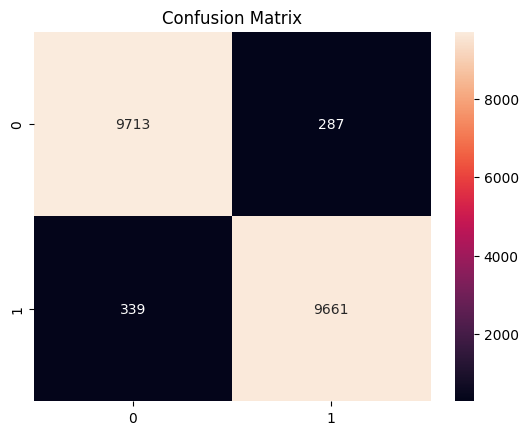

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.show()

evaluate(model, test_loader)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=68ae1fbb724c958d750a1e6e5c4f4039d1e609e6982feb8249b1a49142519ddb
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
Confidence: tensor([[1.0000e+00, 3.4075e-08]], device='cuda:0')


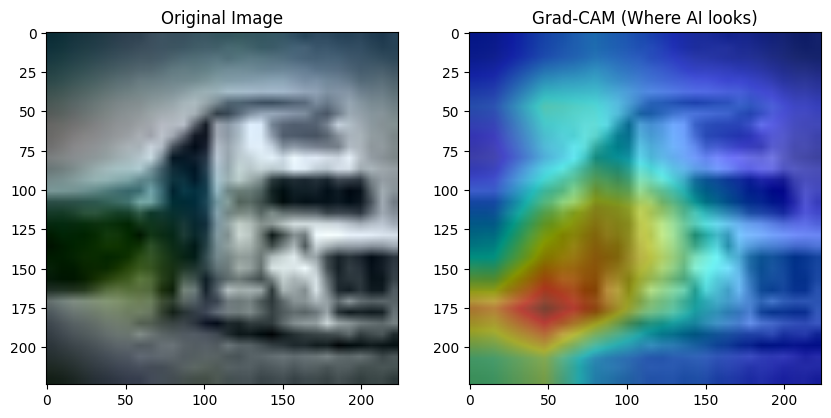

In [18]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_decision(model, img_tensor, label):
    model.eval()
    # ResNet-18 last conv layer is usually model.layer4[-1]
    target_layers = [model.layer4[-1]]

    # Construct the CAM object
    cam = GradCAM(model=model, target_layers=target_layers)

    # Generate heatmap for the specific class (0 for Fake, 1 for Real)
    targets = [ClassifierOutputTarget(label)]
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0).to(device), targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Prepare image for display (denormalize)
    img_show = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_show = (img_show * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_show = np.clip(img_show, 0, 1)

    visualization = show_cam_on_image(img_show, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_show)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM (Where AI looks)")
    plt.show()

# Test it on a FAKE image from the test set
img, lbl = test_dataset[0]
with torch.no_grad():
    outputs = model(img.unsqueeze(0).to(device))
    probs = torch.softmax(outputs, dim=1)
    print("Confidence:", probs)
visualize_decision(model, img, lbl)

In [19]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print("Using device:", device)
print("Classes:", test_dataset.classes)

FAKE_LABEL = test_dataset.classes.index("FAKE")
REAL_LABEL = test_dataset.classes.index("REAL")

Using device: cuda
Classes: ['FAKE', 'REAL']


In [20]:
def get_confident_fake_image(model, dataset, threshold=0.90):
    model.eval()

    for img, label in dataset:
        if label != FAKE_LABEL:
            continue

        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img)
            probs = torch.softmax(output, dim=1)
            fake_conf = probs[0][FAKE_LABEL].item()
            pred = torch.argmax(probs, dim=1).item()

        if pred == FAKE_LABEL and fake_conf > threshold:
            print(f"Selected fake image with confidence {fake_conf:.4f}")
            return img

    raise ValueError("No high-confidence fake found.")

In [21]:
def evaluate(model, image, stage=""):
    model.eval()
    with torch.no_grad():
        output = model(image)
        probs = torch.softmax(output, dim=1)

        fake_conf = probs[0][FAKE_LABEL].item()
        real_conf = probs[0][REAL_LABEL].item()
        pred = torch.argmax(probs, dim=1).item()

    print(f"{stage}")
    print(f"Prediction: {test_dataset.classes[pred]}")
    print(f"Fake Confidence: {fake_conf:.4f}")
    print(f"Real Confidence: {real_conf:.4f}")
    print("-" * 40)

    return fake_conf, real_conf

In [ ]:
def targeted_pgd_attack(model, image, target_label,epsilon=0.03, alpha=0.003, steps=20):

    original = image.clone().detach()
    adv = image.clone().detach().requires_grad_(True)

    confidence_log = []

    for step in range(steps):

        output = model(adv)
        loss = F.cross_entropy(output, target_label)

        model.zero_grad()
        loss.backward()

        # Targeted attack: minimize loss toward REAL
        adv = adv - alpha * adv.grad.sign()

        # Project into epsilon-ball
        perturbation = torch.clamp(adv - original,
                                   min=-epsilon,
                                   max=epsilon)
        adv = original + perturbation

        # Keep within reasonable normalized bounds
        adv = torch.clamp(adv, -3, 3)

        adv = adv.detach().requires_grad_(True)

        # Log REAL confidence
        with torch.no_grad():
            probs = torch.softmax(model(adv), dim=1)
            real_conf = probs[0][REAL_LABEL].item()
            confidence_log.append(real_conf)

    return adv, confidence_log